Notebook to plot clustered info on pclass.

James Ruppert  
jruppert@ou.edu  
10/7/24

### Main settings

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from precip_class import *
from read_functions import *
import seaborn as sns
from scipy.ndimage import label, sum as ndi_sum
import pickle
import pandas as pd
from scipy import stats

In [37]:
t1_test=12 # max of 48
t1_test=48 # max of 48

storm = 'haiyan'
# storm = 'maria'

# Write out pickle file?
do_write=True
do_write=False

# main_pickle = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/jruppert/tc_postproc/"+storm+'/'
main_pickle = "/Users/jamesruppert/code/tc_postproc/"+storm+'/'
main = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/"+storm+'/'
datdir2 = 'post/d02/'

# pclass_names = ['noncloud','deepc','congest','shallowc','strat','anvil']
pclass_names=["Non-cloud", "DeepC", "Congestus", "Shallow", "Stratiform", "Anvil"]
npclass=len(pclass_names)

# Tests to read and compare
if storm == 'haiyan':
    tests = ['ctl','STRATANVIL_ON','ncrf36h','STRATANVIL_OFF','STRAT_OFF']
    tests_str = ['CTL','CONVOFF','NCRF','STRATANVOFF','STRATOFF']
    # tests = ['ctl','ncrf36h']
    # tests_str = ['CTL','NCRF']
    # tests = ['crfon','ncrf']
elif storm == 'maria':
    # tests = ['ctl','ncrf36h']
    tests = ['ctl','ncrf48h']
    tests_str = ['CTL','NCRF']
ntest=len(tests_str)

# Members
nmem = 10 # number of ensemble members (1-5 have NCRF)
# nmem = 1

In [38]:
# Ensemble member info
memb0=1 # Starting member to read
memb_nums=np.arange(memb0,nmem+memb0,1)
memb_nums_str=memb_nums.astype(str)
nustr = np.char.zfill(memb_nums_str, 2)
memb_all=np.char.add('memb_',nustr)

### Main read loop

In [39]:
nt=t1_test

# Arrays to save variables
dims = (ntest, nmem, npclass, nt)
number = np.full(dims, np.nan)
mean_size = np.full(dims, np.nan)

for itest in range(ntest):
# for itest in range(1,2):

    test_str=tests_str[itest]
    test_read=tests[itest]
    print('Running test: ',test_str)

    # if test_read == 'ctl':
    #     t0=36
    #     # t1=t0+49
    #     # Control test time sample
    #     t1=t0+t1_test
    # else:
    #     t0=0
    #     # t1=49 # max
    #     # Control test time sample
    #     t1=t1_test

    # Loop over ensemble members

    for imemb in range(nmem):

        pickle_file1 = main_pickle+memb_all[imemb]+'/pclass_'+test_read+'_48hrs.pkl'
        pickle_file2 = main_pickle+memb_all[imemb]+'/pclass_cluster_'+test_read+'_'+str(t1_test)+'hrs.pkl'

        if do_write:

            # PCLASS index
            # q_int = read_qcloud(datdir, t0, t1, mask=True, drop=True) # mm
            # pclass = precip_class(q_int)
            with open(pickle_file1, 'rb') as file:
                pclass, ipclass_area = pickle.load(file)

            for it in range(nt):
                for kpclass in range(1,npclass):
                    labeled_matrix, num_features = label(pclass[it,...] == kpclass)
                    cluster_sizes = ndi_sum(pclass[it,...], labeled_matrix, index=np.arange(1, num_features + 1))
                    number[itest, imemb, kpclass, it] = num_features
                    mean_size[itest, imemb, kpclass, it] = np.mean(cluster_sizes)

            with open(pickle_file2, 'wb') as file:
                pickle.dump([number[itest,imemb,...], mean_size[itest,imemb,...]], file)

        else:

            with open(pickle_file2, 'rb') as file:
                inumber, isize = pickle.load(file)
            number[itest,imemb,...]    = inumber
            mean_size[itest,imemb,...] = isize

Running test:  CTL
Running test:  CONVOFF
Running test:  NCRF
Running test:  STRATANVOFF
Running test:  STRATOFF


### Plotting

In [40]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 12}

rc('font', **font)

sns.set_theme(style="darkgrid", rc={'xtick.bottom': True, 'ytick.left': True,})

In [86]:
# Confidence interval using T-test and assuming 95% significance
def mean_confidence_interval(data):
    # conf_set=0.95 # Confidence interval to apply throughout
    conf_set=0.9 # Confidence interval to apply throughout
    a = 1.0 * np.array(data)
    # n = len(a)
    n = a.shape[0]
    m, se = np.mean(a, axis=0), stats.sem(a, axis=0)
    # num = stats.t.ppf((1 + conf_set) / 2., n-1)
    h = se * stats.t.ppf((1 + conf_set) / 2., n-1)
    return m, m-h, m+h

#### Histograms of N and mean size

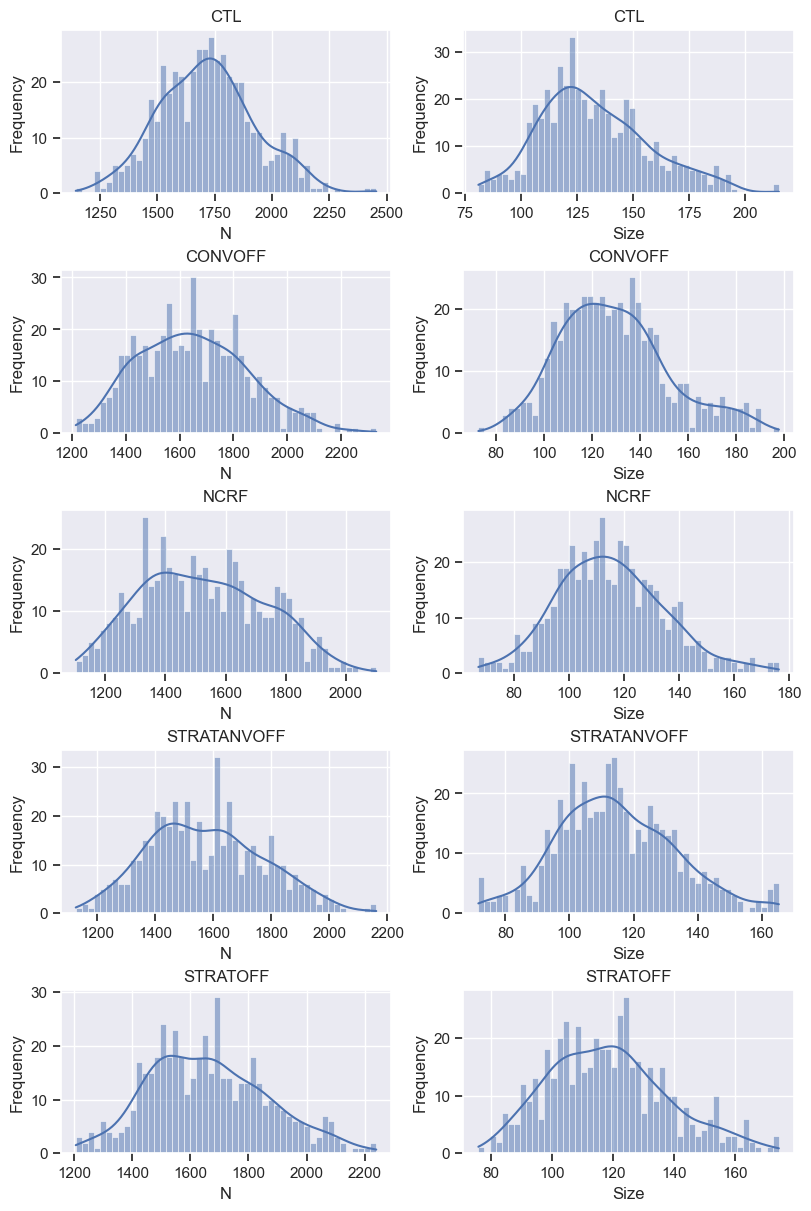

In [41]:
def add_var(figdata, ax):
    ax.set_title(figdata['testtag'])
    ax.set_ylabel('Frequency')
    ax.set_xlabel(figdata['units'])
    sns.histplot(figdata['pltvar'], ax=ax, kde=True, bins=figdata['bins'], legend=True)

fig_x = 8
fig_y = 12
fig, axs = plt.subplots(5, 2, figsize=(fig_x,fig_y), layout='constrained', squeeze=True)
# fig, axs = plt.subplots(layout='constrained', squeeze=True)

kpclass=4

for itest in range(ntest):

    figdata = {
        'pltvar': number[itest,:,kpclass,:].flatten(), # dims = (ntest, nmem, npclass, nt)
        'testtag': tests_str[itest],
        'units': 'N',
        'bins': 50,
        }

    add_var(figdata, axs[itest,0])

    figdata = {
        'pltvar': mean_size[itest,:,kpclass,:].flatten(), # dims = (ntest, nmem, npclass, nt)
        'testtag': tests_str[itest],
        'units': 'Size',
        'bins': 50,
        }

    add_var(figdata, axs[itest,1])
    # add_var(figdata, axs[0,1])

plt.show()
plt.close()

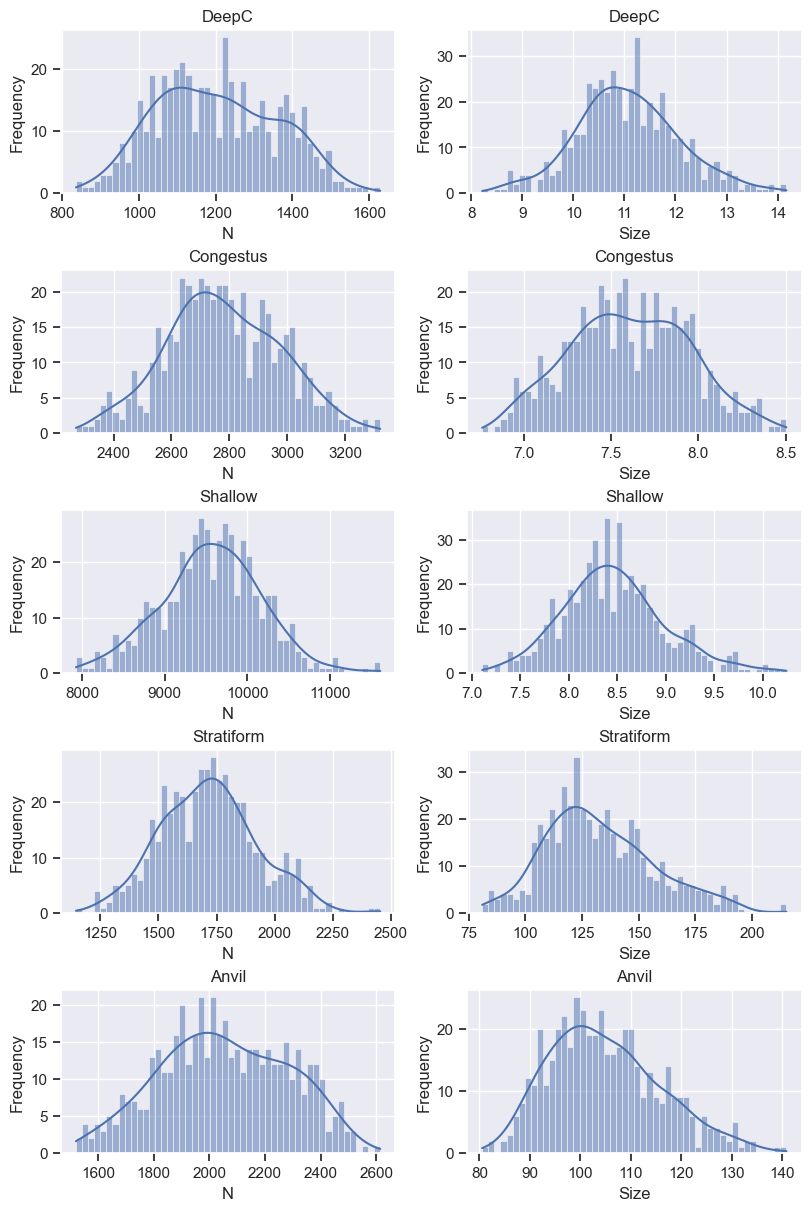

In [42]:
def add_var(figdata, ax):
    ax.set_title(figdata['pclass_str'])
    ax.set_ylabel('Frequency')
    ax.set_xlabel(figdata['units'])
    sns.histplot(figdata['pltvar'], ax=ax, kde=True, bins=figdata['bins'], legend=True)

fig_x = 8
fig_y = 12
fig, axs = plt.subplots(5, 2, figsize=(fig_x,fig_y), layout='constrained', squeeze=True)
# fig, axs = plt.subplots(layout='constrained', squeeze=True)

itest=0

for kpclass in range(1,npclass):

    figdata = {
        # 'pltvar': number[itest,:,kpclass,:].flatten(), # dims = (ntest, nmem, npclass, nt)
        'pltvar': number[itest,:,kpclass,:].flatten(), # dims = (ntest, nmem, npclass, nt)
        'pclass_str': pclass_names[kpclass],
        'units': 'N',
        'bins': 50,
        }

    add_var(figdata, axs[kpclass-1,0])

    figdata = {
        # 'pltvar': mean_size[itest,:,kpclass,:].flatten(), # dims = (ntest, nmem, npclass, nt)
        'pltvar': mean_size[itest,:,kpclass,:].flatten(), # dims = (ntest, nmem, npclass, nt)
        'pclass_str': pclass_names[kpclass],
        'units': 'Size',
        'bins': 50,
        }

    add_var(figdata, axs[kpclass-1,1])
    # add_var(figdata, axs[0,1])

plt.show()
plt.close()

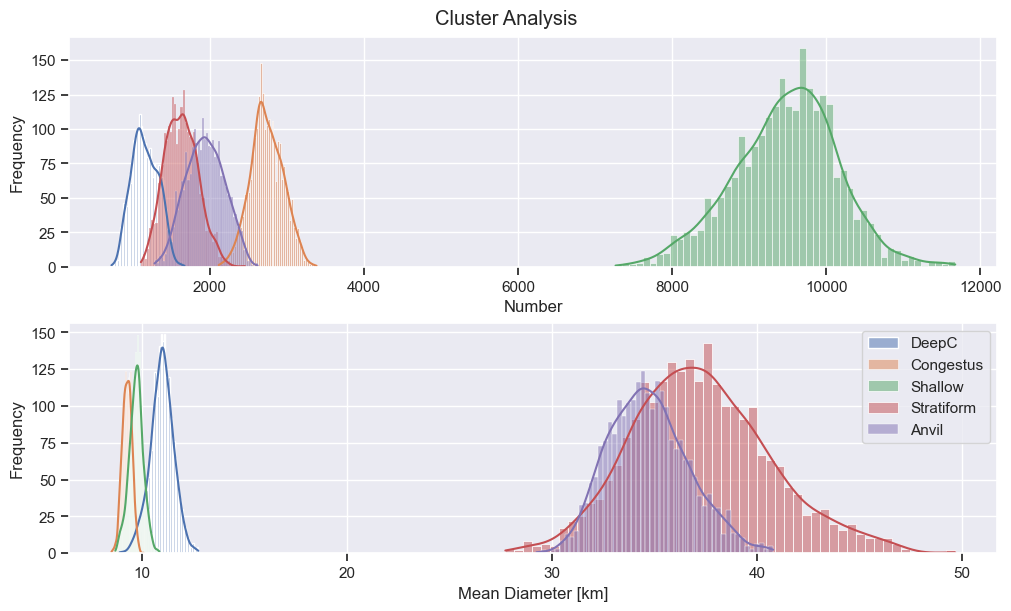

In [43]:
def add_var(figdata, ax):
    ax.set_ylabel('Frequency')
    ax.set_xlabel(figdata['units'])
    sns.histplot(figdata['pltvar'], ax=ax, kde=True, bins=figdata['bins'], legend=True, label=figdata['pclass_str'])

fig_x = 10
fig_y = 6
fig, axs = plt.subplots(2, 1, figsize=(fig_x,fig_y), layout='constrained', squeeze=True)
# fig, axs = plt.subplots(layout='constrained', squeeze=True)

# itest=0

for kpclass in range(1,npclass):

    figdata = {
        # 'pltvar': number[itest,:,kpclass,:].flatten(), # dims = (ntest, nmem, npclass, nt)
        'pltvar': number[:,:,kpclass,:].flatten(), # dims = (ntest, nmem, npclass, nt)
        'pclass_str': pclass_names[kpclass],
        'units': 'Number',
        'bins': 50,
        }

    add_var(figdata, axs[0])

    # diam=np.sqrt(3**2 + 3**2)
    # Assume circular geometry
    # area = mean_size
    # area = pi*r^2
    # r = np.sqrt(area/pi)
    area_grid_cell = 9 # km**2
    diam = 2*np.sqrt((mean_size*area_grid_cell)/np.pi)

    figdata = {
        # 'pltvar': mean_size[itest,:,kpclass,:].flatten(), # dims = (ntest, nmem, npclass, nt)
        # 'pltvar': mean_size[:,:,kpclass,:].flatten()*diam, # dims = (ntest, nmem, npclass, nt)
        'pltvar': diam[:,:,kpclass,:].flatten(), # dims = (ntest, nmem, npclass, nt)
        'pclass_str': pclass_names[kpclass],
        'units': 'Mean Diameter [km]',
        'bins': 50,
        }

    add_var(figdata, axs[1])
    # add_var(figdata, axs[0,1])

# axs[0].set_title('Number')
# axs[1].set_title('Mean Size')
plt.suptitle('Cluster Analysis')

plt.legend()
plt.show()
plt.close()

#### KDE or Box Plots

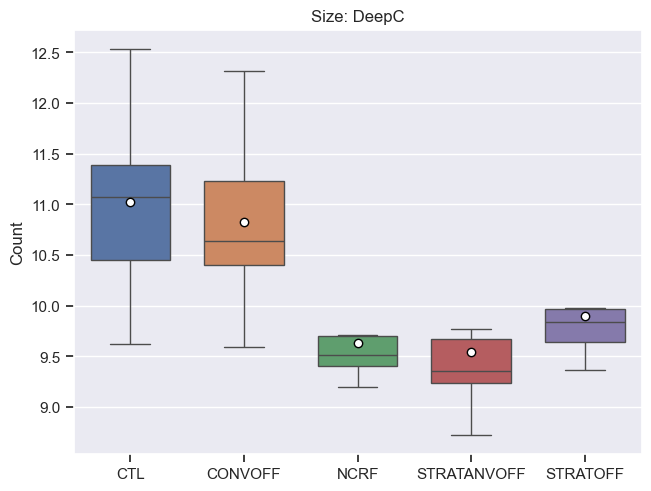

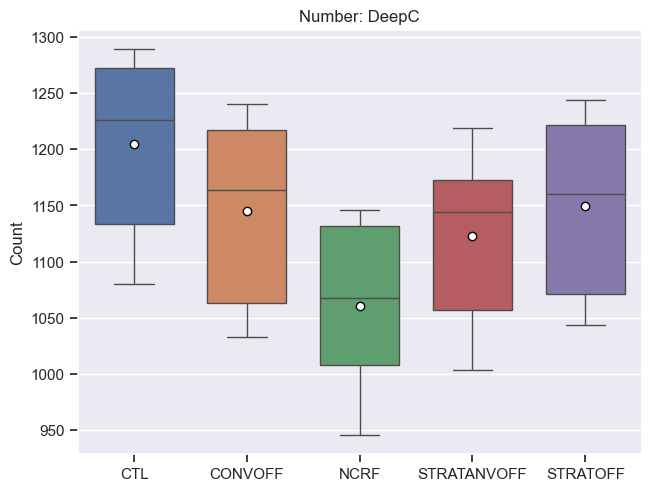

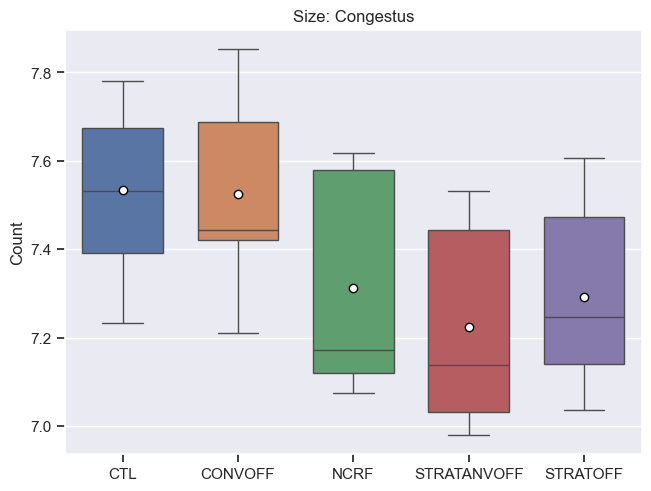

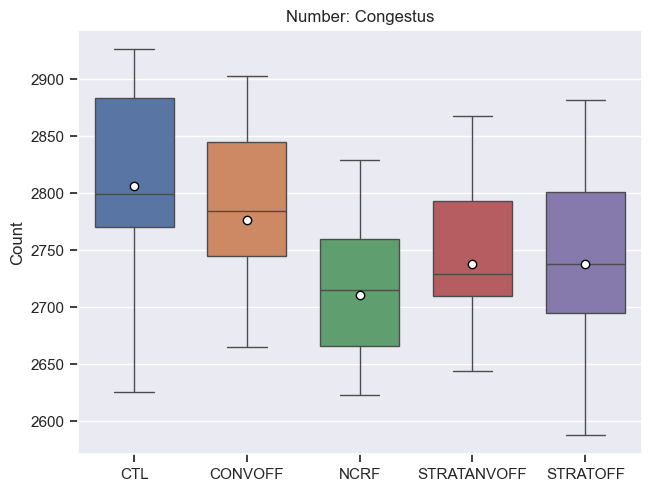

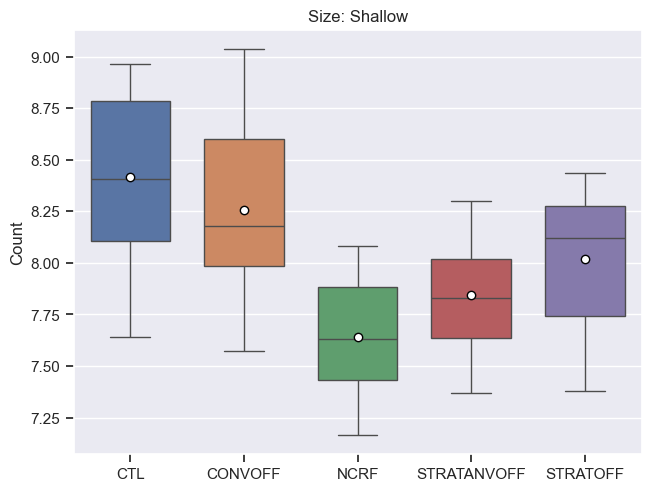

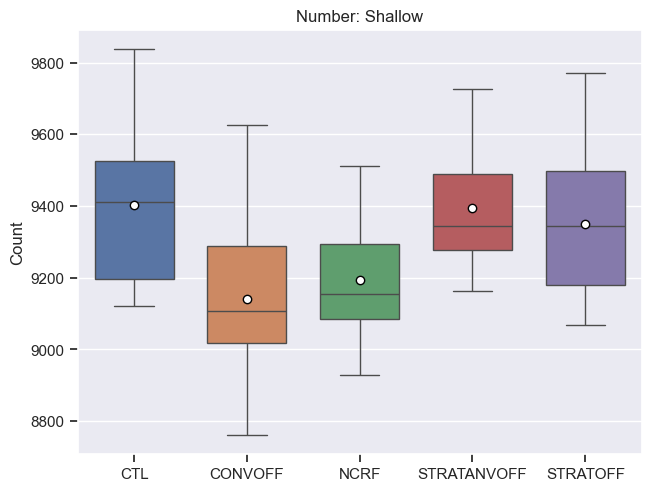

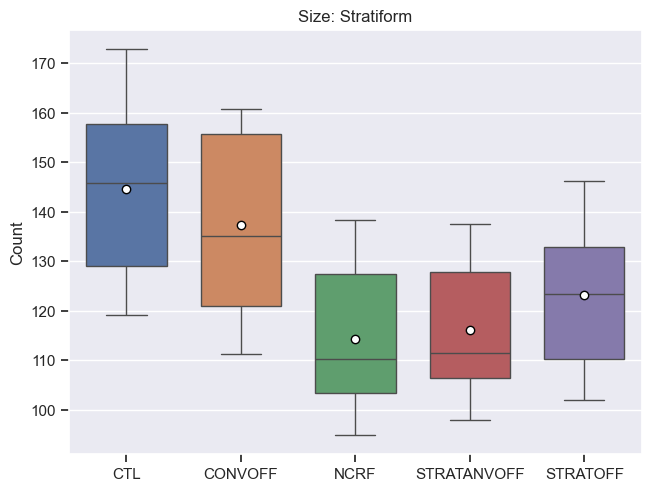

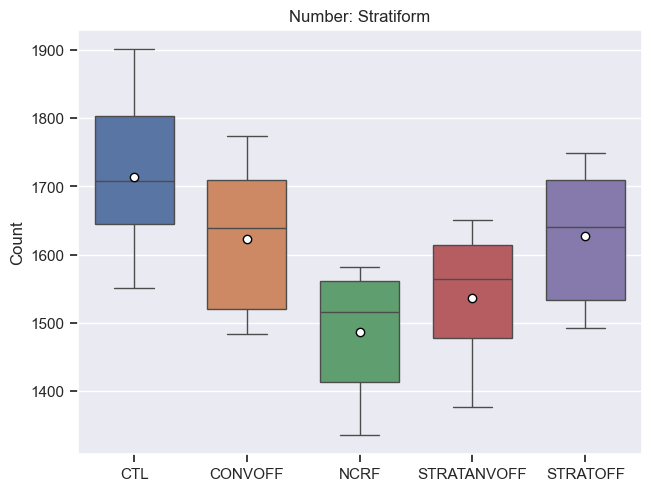

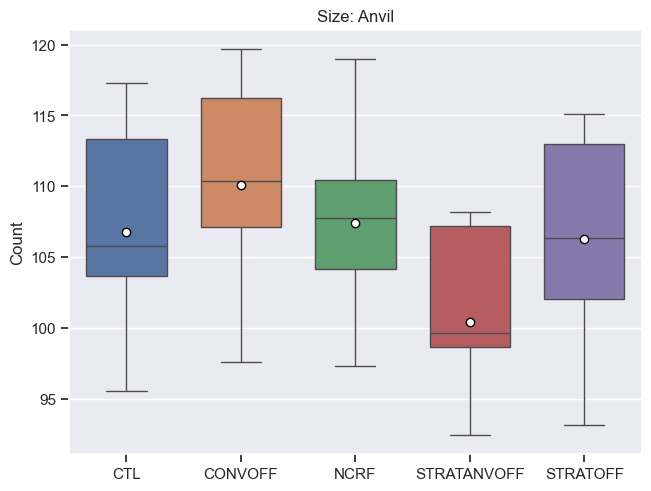

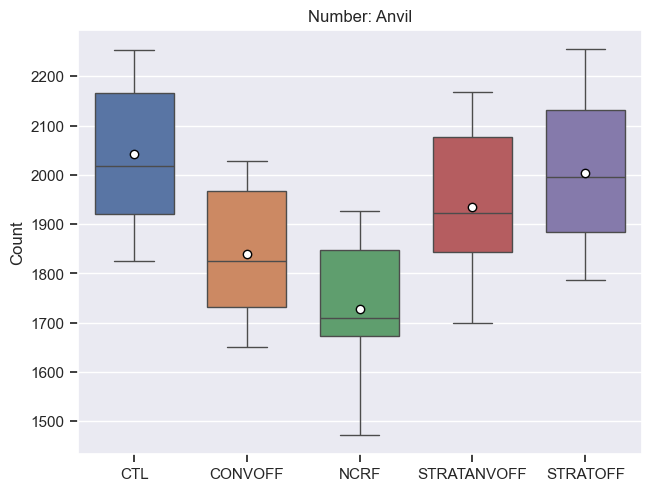

In [82]:
def do_kdeplot(figdata):
    fig, ax = plt.subplots(layout='constrained', squeeze=True)
    ax.set_title(figdata['units'])
    ax.set_ylabel('Count')
    # ax.set_xlabel(figdata['units'])
    # ntnew=figdata['pltvar'].shape[2]
    # df = pd.DataFrame(data=np.reshape(figdata['pltvar'], (ntest, nmem*ntnew)).transpose(), columns=tests_str)
    df = pd.DataFrame(data=np.reshape(figdata['pltvar'], (ntest, nmem)).transpose(), columns=tests_str)
    # sns.kdeplot(df, ax=ax, legend=True)
    sns.boxplot(df,
                width=0.7, showmeans=True, showfliers=False,
                meanprops={"marker":"o", "markerfacecolor":"white", 
                "markeredgecolor":"black", "markersize":"6"})
    plt.show()
    plt.close()

# t_ind=np.arange(t1_test)
t_ind=np.arange(24,48)
mean_size_mn = np.mean(mean_size[:,:,:,t_ind], axis=3)
number_mn = np.mean(number[:,:,:,t_ind], axis=3)

for kpclass in range(1,npclass):

    figdata = {
        # 'pltvar': mean_size[:,:,kpclass,t_ind], # dims = (ntest, nmem, npclass, nt)
        'pltvar': mean_size_mn[:,:,kpclass], # dims = (ntest, nmem, npclass, nt)
        'testtag': tests_str[itest],
        'units': 'Size: '+pclass_names[kpclass],
        }

    do_kdeplot(figdata)

    figdata = {
        # 'pltvar': number[:,:,kpclass,t_ind], # dims = (ntest, nmem, npclass, nt)
        'pltvar': number_mn[:,:,kpclass], # dims = (ntest, nmem, npclass, nt)
        'testtag': tests_str[itest],
        'units': 'Number: '+pclass_names[kpclass],
        }

    do_kdeplot(figdata)

#### Time series

In [138]:
def do_smooth(invar, nt_smooth=3):
    # Use Pandas to compute rolling average
    invar_pd = pd.DataFrame(invar.transpose())
    var_sm1 = invar_pd.rolling(window=nt_smooth, center=True, closed='both', min_periods=3).mean()
    return np.squeeze(np.array(var_sm1).transpose())

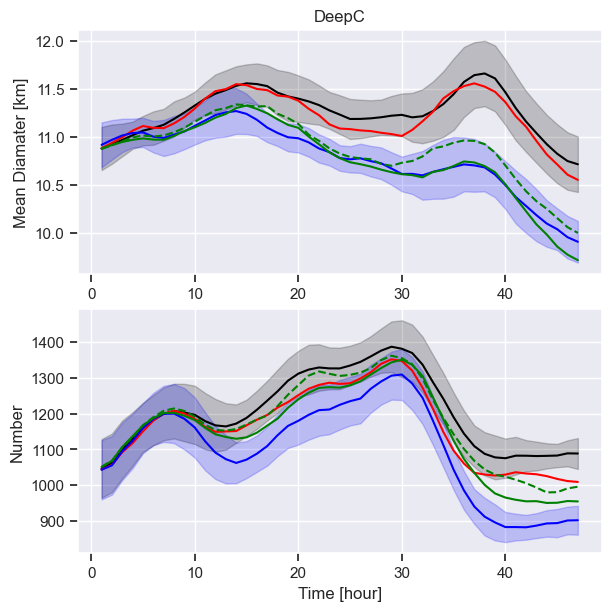

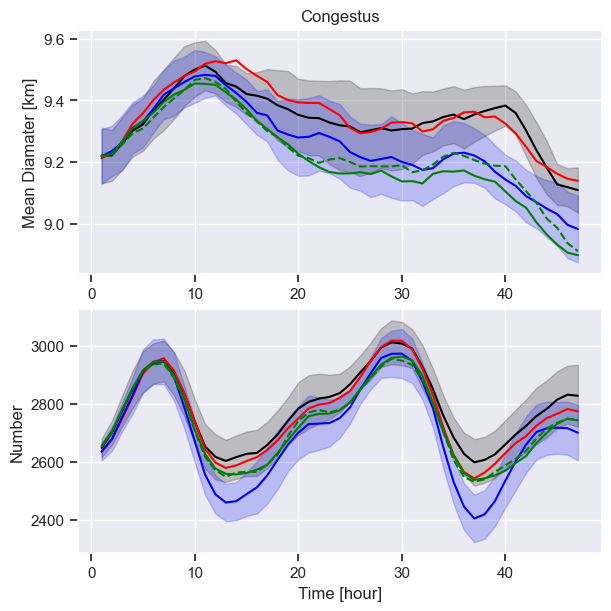

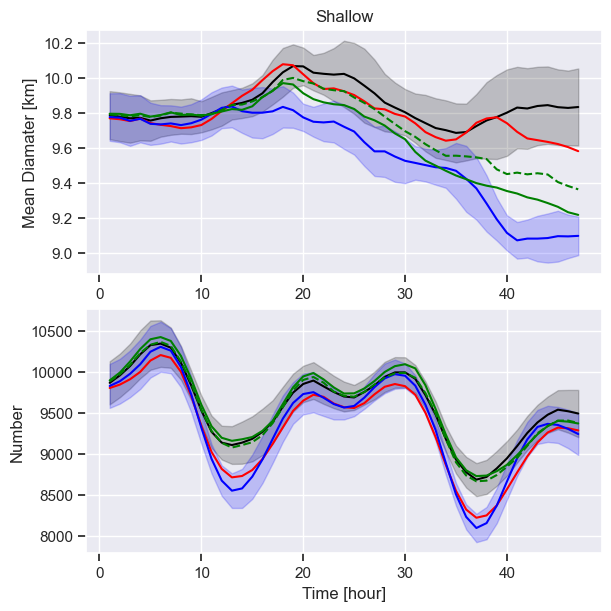

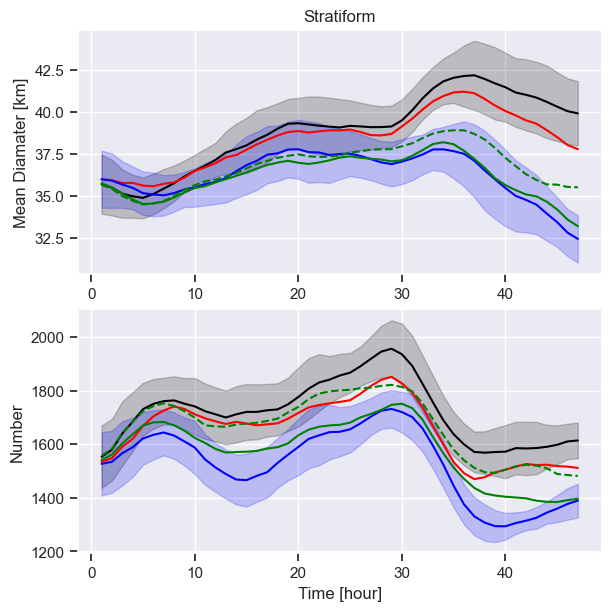

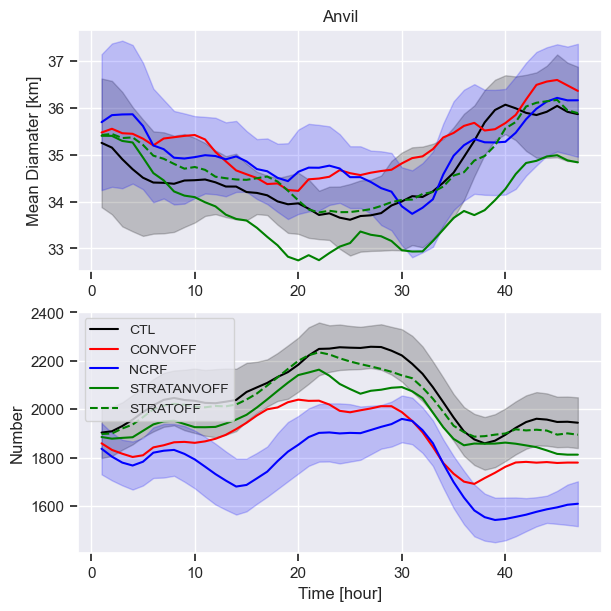

In [141]:
def do_tser(figdata, do_legend=False):
    smooth=True
    # smooth=False
    fig_x, fig_y = 6, 6
    fig, ax = plt.subplots(2,1, figsize=(fig_x,fig_y), layout='constrained', squeeze=True)
    ax[0].set_title(figdata['units'])
    # ax[0].set_title('Mean Diamater [km]')
    # ax[1].set_title('Number [km]')
    ax[0].set_ylabel('Mean Diamater [km]')
    ax[1].set_ylabel('Number')
    # ax[0].set_xlabel('Time [hour]')
    ax[1].set_xlabel('Time [hour]')
    linecolor=['black', 'red', 'blue', 'green', 'green']
    linestyle=['solid']*ntest # this creates an array of ['solid'] of size ntest
    linestyle[-1]='dashed'
    for iax in range(2):
        if iax == 0:
            pltvar = figdata['size']
        else:
            pltvar = figdata['number']
        for itest in range(ntest):
            pvar = pltvar[itest]
            if smooth:
                pvar = do_smooth(pvar)
            mean, low, high = mean_confidence_interval(pvar)
            ax[iax].plot(mean, linestyle=linestyle[itest], color=linecolor[itest], label=tests_str[itest])
            # var_smooth = pd.DataFrame(mean)
            # var_smooth = var_smooth.rolling(window=3, center=True, closed='both').mean()
            # ax[iprof].plot(var_smooth, linestyle=linestyle[itest], color=linecolor[itest], label=tests_str[itest])
            if (itest == 0) or (itest == 2):
                xdim = range(0,mean.shape[0])
                ax[iax].fill_between(xdim, high, low, alpha=0.2, color=linecolor[itest])
    if do_legend:
        plt.legend(loc='upper left', prop={'size': 10})
    plt.show()
    plt.close()

area_grid_cell = 9 # km**2
diam = 2*np.sqrt((mean_size*area_grid_cell)/np.pi)

for kpclass in range(1,npclass):

    figdata = {
        # 'size': mean_size[:,:,kpclass,:], # dims = (ntest, nmem, npclass, nt)
        'size': diam[:,:,kpclass,:], # dims = (ntest, nmem, npclass, nt)
        'number': number[:,:,kpclass,:], # dims = (ntest, nmem, npclass, nt)
        'testtag': tests_str[itest],
        'units': pclass_names[kpclass],
        }

    do_legend=False
    if kpclass == npclass-1:
        do_legend=True

    do_tser(figdata, do_legend=do_legend)

In [ ]:
# def do_tser(figdata):
#     fig, ax = plt.subplots(layout='constrained', squeeze=True)
#     ax.set_title(figdata['units'])
#     ax.set_ylabel('Count')
#     ax.set_xlabel('Time [hour]')
#     linecolor=['black', 'red', 'blue', 'green', 'green']
#     linestyle=['solid']*ntest # this creates an array of ['solid'] of size ntest
#     linestyle[-1]='dashed'
#     for itest in range(ntest):
#         # ax.plot(figdata['pltvar'][itest].transpose(), label=tests_str[itest])
#         mean, low, high = mean_confidence_interval(figdata['pltvar'][itest])
#         ax.plot(mean, linestyle=linestyle[itest], color=linecolor[itest], label=tests_str[itest])
#         # var_smooth = pd.DataFrame(mean)
#         # var_smooth = var_smooth.rolling(window=3, center=True, closed='both').mean()
#         # ax[iprof].plot(var_smooth, linestyle=linestyle[itest], color=linecolor[itest], label=tests_str[itest])
#         if (itest == 0) or (itest == 2):
#             xdim = range(0,nt)
#             ax.fill_between(xdim, high, low, alpha=0.2, color=linecolor[itest])
#     plt.legend()
#     plt.show()
#     plt.close()

# for kpclass in range(1,npclass):

#     figdata = {
#         'pltvar': mean_size[:,:,kpclass,:], # dims = (ntest, nmem, npclass, nt)
#         'testtag': tests_str[itest],
#         'units': 'Size: '+pclass_names[kpclass],
#         }

#     do_tser(figdata)

#     figdata = {
#         'pltvar': number[:,:,kpclass,:], # dims = (ntest, nmem, npclass, nt)
#         'testtag': tests_str[itest],
#         'units': 'Number: '+pclass_names[kpclass],
#         }

#     do_tser(figdata)

#### Check N*size ~~ area

In [80]:
# def do_kdeplot(figdata):
#     fig, ax = plt.subplots(layout='constrained', squeeze=True)
#     ax.set_title(figdata['units'])
#     ax.set_ylabel('Count')
#     # ax.set_xlabel(figdata['units'])
#     print(figdata['pltvar'].shape)
#     ntnew=figdata['pltvar'].shape[2]
#     print(npclass,nmem, ntnew)
#     df = pd.DataFrame(data=np.reshape(figdata['pltvar'], (npclass-1, nmem*ntnew)).transpose(), columns=pclass_names[1:])
#     # sns.kdeplot(df, ax=ax, legend=True)
#     sns.boxplot(df,
#                 width=0.7, showmeans=True, showfliers=False,
#                 meanprops={"marker":"o", "markerfacecolor":"white", 
#                 "markeredgecolor":"black", "markersize":"6"})

# # t_ind=range(t1_test)
# # t_ind=range(6)

# mean_size_ts = np.transpose(mean_size, axes=(2,0,1,3))
# number_ts = np.transpose(number, axes=(2,0,1,3))

# # for kpclass in range(1,npclass):
# itest=0
# figdata = {
#     # 'pltvar': mean_size[itest,:,kpclass,t_ind]*number[itest,:,kpclass,t_ind]/(ntest*nmem*6), # dims = (ntest, nmem, npclass, nt)
#     'pltvar': mean_size_ts[1:,itest,:,0:6]*number_ts[1:,itest,:,0:6], # dims = (ntest, nmem, npclass, nt)
#     'units': 'N*Size',
#     }

# do_kdeplot(figdata)

#### Box plots of full cluster size distribution

In [46]:
# # Function to get full distribution of cluster sizes

# def get_cluster_sizes(nt_read):

#     dims = (npclass, ntest, nmem)
#     number = np.zeros(dims)

#     cluster_size_allclass=[]
#     for kpclass in range(npclass):

#         cluster_size_alltest=[]
#         for itest in range(ntest):
#             # Loop over ensemble members
#             for imemb in range(nmem):

#                 pickle_file1 = main_pickle+memb_all[imemb]+'/pclass_'+tests[itest]+'_48hrs.pkl'
#                 with open(pickle_file1, 'rb') as file:
#                     pclass, ipclass_area = pickle.load(file)

#                 for it in range(nt_read):
#                     labeled_matrix, num_features = label(pclass[it,...] == kpclass)
#                     icluster_size = ndi_sum(pclass[it,...], labeled_matrix, index=np.arange(1, num_features + 1))
#                     number[kpclass, itest, imemb] += num_features
#                     if it == 0:
#                         cluster_size = np.copy(icluster_size)
#                     else:
#                         cluster_size = np.concatenate((cluster_size, icluster_size))

#                 if imemb == 0:
#                     cluster_size_allmemb = np.copy(cluster_size)
#                 else:
#                     cluster_size_allmemb = np.concatenate((cluster_size_allmemb, cluster_size))

#             cluster_size_alltest.append(cluster_size_allmemb)
#         cluster_size_allclass.append(cluster_size_alltest)

#     return cluster_size_allclass, number

In [47]:
# # Plot function
# def do_cluster_plot(figdata):
#     fig, ax = plt.subplots(layout='constrained', squeeze=True)
#     ax.set_title(figdata['units'])
#     ax.set_ylabel('Count')
#     # df = pd.DataFrame(data=figdata['pltvar'], index=tests_str)
#     pltvar_dict = {tests_str[itest]: figdata['pltvar'][itest] for itest in range(ntest)}
#     sns.boxplot(pltvar_dict,
#                 width=0.7, showmeans=True, showfliers=False,
#                 meanprops={"marker":"o", "markerfacecolor":"white", 
#                 "markeredgecolor":"black", "markersize":"6"},
#                 )

# # Sampling window
# nt_read = 6

# cluster_size, number = get_cluster_sizes(nt_read)

# for kpclass in range(1,npclass):
# # kpclass=1
#     figdata = {
#         'pltvar': cluster_size[kpclass], # npclass, ntest, n-flattened-clusters
#         'units': 'Cluster Size: '+pclass_names[kpclass],
#         }
#     do_cluster_plot(figdata)